In [162]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlmicrophysics.models import DenseNeuralNetwork
from mlmicrophysics.data import subset_data_files_by_date, log10_transform, neg_log10_transform
from sklearn.preprocessing import StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import r2_score
from matplotlib.colors import LogNorm
scalers = {"MinMaxScaler": MinMaxScaler,
           "MaxAbsScaler": MaxAbsScaler,
           "StandardScaler": StandardScaler,
           "RobustScaler": RobustScaler}
transforms = {"log10_transform": log10_transform,
              "neg_log10_transform": neg_log10_transform}

/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
path = "/glade/scratch/dgagne/cam_mp_files_run2_csv/"
train_files, val_files, test_files = subset_data_files_by_date(path, ".csv", train_date_start=0, train_date_end=4000, 
                                                               test_date_start=4100, test_date_end=6000)

[    0   123   246   369   492   615   738   861   984  1107  1230  1353
  1476  1599  1722  1845  1968  2091  2214  2337  2460  2583  2706  2829
  2952  3075  3198  3321  3444  3567  3690  3813  3936  4059  4182  4305
  4428  4551  4674  4797  4920  5043  5166  5289  5412  5535  5658  5781
  5904  6027  6150  6273  6396  6519  6642  6765  6888  7011  7134  7257
  7380  7503  7626  7749  7872  7995  8118  8241  8364  8487  8610  8733
  8856  8979  9102  9225  9348  9471  9594  9717  9840  9963 10086 10209
 10332 10455 10578 10701 10824 10947 11070 11193 11316 11439 11562 11685
 11808 11931 12054 12177 12300 12423 12546 12669 12792 12915 13038 13161
 13284 13407 13530 13653 13776 13899 14022 14145 14268 14391 14514 14637
 14760 14883 15006 15129 15252 15375 15498 15621 15744 15867 15990 16113
 16236 16359 16482 16605 16728 16851 16974 17097 17220 17343 17466]


In [31]:
input_cols = ["pressure", "temperature", "RHO_CLUBB_lev", "RHO_CLUBB_top", "RHO_CLUBB_bottom",
             "QC_TAU_in", "NC_TAU_in", "QR_TAU_in", "NR_TAU_in",]
output_cols = ["qctend_TAU", "qrtend_TAU", "nctend_TAU", "nrtend_TAU"]
all_input_data = []
all_output_data = []
for filename in train_files:
    print(filename)
    data = pd.read_csv(filename, index_col="Index")
    data = data.loc[data["NC_TAU_in"] >= 10]
    all_input_data.append(data[input_cols])
    all_output_data.append(data[output_cols])
    del data
print("Combining data")
combined_input_data = pd.concat(all_input_data, ignore_index=True)
combined_output_data = pd.concat(all_output_data, ignore_index=True)
del all_input_data[:]
del all_output_data[:]

/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000123.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000246.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000492.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000615.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000861.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_000984.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001230.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001353.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001599.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001722.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_001968.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002091.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002337.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_002

In [53]:
all_input_data = []
all_output_data = []
for filename in test_files:
    print(filename)
    data = pd.read_csv(filename, index_col="Index")
    data = data.loc[data["NC_TAU_in"] >= 10]
    all_input_data.append(data[input_cols])
    all_output_data.append(data[output_cols])
    del data
print("Combining data")
test_input_data = pd.concat(all_input_data, ignore_index=True)
test_output_data = pd.concat(all_output_data, ignore_index=True)
del all_input_data[:]
del all_output_data[:]

/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004182.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004305.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004428.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004551.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004674.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004797.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_004920.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005043.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005166.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005289.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005412.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005535.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005658.csv
/glade/scratch/dgagne/cam_mp_files_run2_csv/cam_mp_data_run2_005

(array([[nan, nan,  1., ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([1.00025394, 1.0806814 , 1.16110885, 1.24153631, 1.32196376,
        1.40239122, 1.48281867, 1.56324613, 1.64367358, 1.72410104,
        1.80452849, 1.88495595, 1.9653834 , 2.04581086, 2.12623831,
        2.20666577, 2.28709322, 2.36752068, 2.44794813, 2.52837559,
        2.60880304, 2.6892305 , 2.76965795, 2.85008541, 2.93051286,
        3.01094032, 3.09136777, 3.17179523, 3.25222268, 3.33265014,
        3.41307759, 3.49350505, 3.5739325 , 3.65435996, 3.73478741,
        3.81521487, 3.89564232, 3.97606978, 4.05649723, 4.13692469,
        4.21735214, 4.2977796 , 4.37820705, 4.45863451, 4.53906196,
        4.61948942, 4.69991687, 4.78034433, 4.86077178, 4.94119924,
        5.02162669, 5.10205415, 5.1

/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


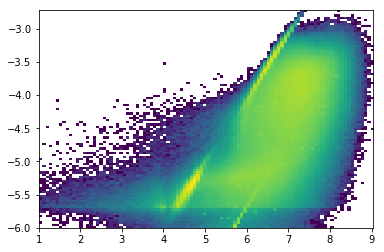

In [32]:
plt.hist2d(np.log10(combined_input_data["NC_TAU_in"]), np.log10(combined_input_data["QC_TAU_in"]), 
           bins=100, cmin=1, norm=LogNorm() )

(array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-1.20600920e-05, -1.19394911e-05, -1.18188902e-05, -1.16982892e-05,
        -1.15776883e-05, -1.14570874e-05, -1.13364865e-05, -1.12158856e-05,
        -1.10952846e-05, -1.09746837e-05, -1.08540828e-05, -1.07334819e-05,
        -1.06128810e-05, -1.04922800e-05, -1.03716791e-05, -1.02510782e-05,
        -1.01304773e-05, -1.00098764e-05, -9.88927544e-06, -9.76867452e-06,
        -9.64807360e-06, -9.52747268e-06, -9.40687176e-06, -9.28627084e-06,
        -9.16566992e-06, -9.04506900e-06, -8.92446808e-06, -8.80386716e-06,
        -8.68326624e-06, -8.56266532e-06, -8.44206440e-06, -8.32146348e-06,
        -8.20086256e-06, -8.08026164e-06, -7.95966072e-06, -7.83905980e-06,
        -7.71845888e-06, -7.597

/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


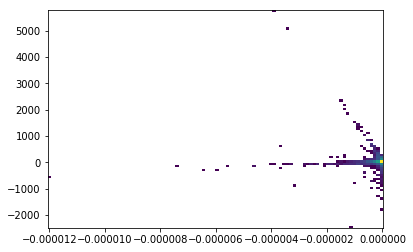

In [33]:
plt.hist2d(combined_output_data["qctend_TAU"], combined_output_data["nrtend_TAU"], 
           bins=100, cmin=1, norm=LogNorm() )

In [154]:
dnn = DenseNeuralNetwork(hidden_layers=3, hidden_neurons=100, 
                         inputs=len(input_cols), outputs=1, 
                         loss="mse", activation="selu", epochs=10, batch_size=1024, verbose=1, l2_weight=0.0001, lr=0.0001 )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               1000      
_________________________________________________________________
activation_16 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_17 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 100)               10100     
_________________________________________________________________
activation_18 (Activation)   (None, 100)               0         
__________

In [47]:
input_transforms = {
    "QC_TAU_in": "log10_transform",
    "NC_TAU_in": "log10_transform",
    "QR_TAU_in": "log10_transform",
    "NR_TAU_in": "log10_transform"}

for var, transform_name in input_transforms.items():
    combined_input_data.loc[:, var] = transforms[transform_name](combined_input_data[var])


In [55]:
for var, transform_name in input_transforms.items():
    test_input_data.loc[:, var] = transforms[transform_name](test_input_data[var])

In [48]:
scaler = StandardScaler()
scaled_input_data = scaler.fit_transform(combined_input_data)

In [56]:
scaled_test_input = scaler.transform(test_input_data)

In [155]:
dnn.fit(scaled_input_data, np.log10(-combined_output_data.iloc[:, 2]))

Epoch 1/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0513
Epoch 2/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0253
Epoch 3/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0202
Epoch 4/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0175
Epoch 5/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0160
Epoch 6/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0151
Epoch 7/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0146
Epoch 8/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0143
Epoch 9/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0140
Epoch 10/10
3244665/3244665 [==============================] - 17s 5us/step - loss: 0.0138


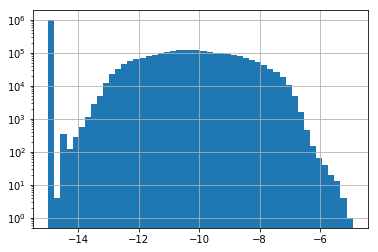

In [113]:
np.log10(np.maximum(-combined_output_data.iloc[:, 0], 1e-15)).hist(bins=50)
plt.gca().set_yscale("log")

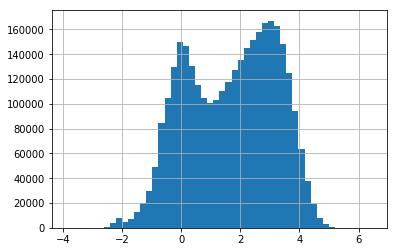

In [117]:
np.log10(np.maximum(-combined_output_data.iloc[:, 2], 1e-15)).hist(bins=50)

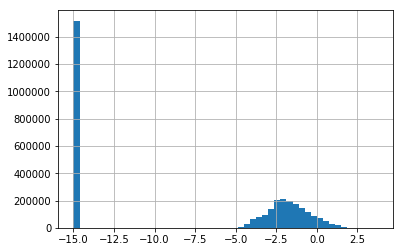

In [119]:
np.log10(np.maximum(combined_output_data.iloc[:, 3], 1e-15)).hist(bins=50)

In [156]:
test_preds = dnn.predict(scaled_test_input)

In [97]:
test_preds.shape

(2426187, 1)

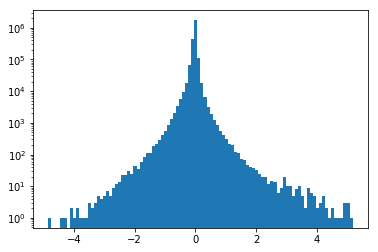

In [157]:
plt.hist(test_preds[:, 0] - np.log10(-test_output_data.iloc[:, 2]), bins=100)
plt.gca().set_yscale("log")

Text(0.5,1,'R2: 0.995')

/glade/u/home/dgagne/miniconda3/envs/deep/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


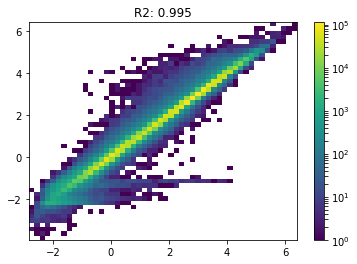

In [165]:
plt.hist2d(test_preds[:, 0], np.log10(-test_output_data.iloc[:, 2]), bins=50, cmin=1, norm=LogNorm())
plt.colorbar()
plt.title("R2: {0:0.3f}".format(r2_score(np.log10(-test_output_data.iloc[:, 2]), test_preds[:, 0])))

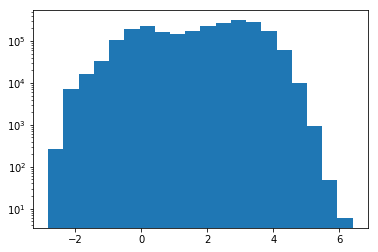

In [158]:
plt.hist(test_preds[:, 0], bins=20)
plt.gca().set_yscale("log")

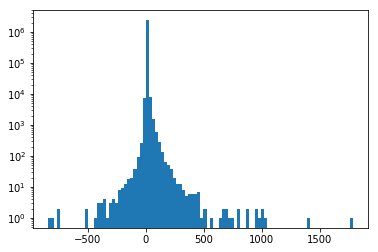

In [120]:
plt.hist(test_output_data.iloc[:, 3], bins=100)
plt.gca().set_yscale("log")

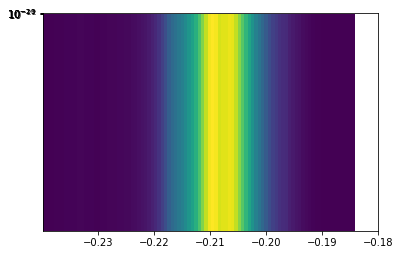

In [69]:
plt.hist2d(test_preds[:, 0], test_output_data.iloc[:, 0], cmin=1, bins=100)

In [79]:
combined_output_data["qrtend_TAU"][combined_output_data["qrtend_TAU"] > 0].min()

1.862227e-15

In [83]:
np.count_nonzero(combined_output_data["nctend_TAU"] == 0)

0

(array([[nan, nan,  1., ..., nan, nan, nan],
        [ 1., nan,  3., ..., nan, nan, nan],
        [ 1.,  1.,  2., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan,  1., nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-5.99999448, -5.93613816, -5.87228183, -5.8084255 , -5.74456918,
        -5.68071285, -5.61685652, -5.5530002 , -5.48914387, -5.42528754,
        -5.36143122, -5.29757489, -5.23371856, -5.16986224, -5.10600591,
        -5.04214958, -4.97829326, -4.91443693, -4.8505806 , -4.78672428,
        -4.72286795, -4.65901162, -4.5951553 , -4.53129897, -4.46744264,
        -4.40358632, -4.33972999, -4.27587366, -4.21201734, -4.14816101,
        -4.08430468, -4.02044836, -3.95659203, -3.8927357 , -3.82887938,
        -3.76502305, -3.70116672, -3.6373104 , -3.57345407, -3.50959774,
        -3.44574142, -3.38188509, -3.31802876, -3.25417244, -3.19031611,
        -3.12645978, -3.06260346, -2.99874713, -2.9348908 

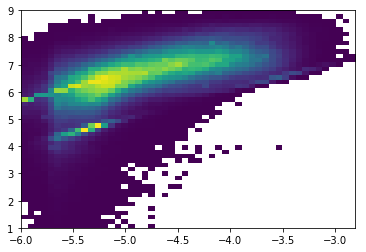

In [124]:
plt.hist2d(combined_input_data.loc[combined_output_data.iloc[:, 1] == 0, "QC_TAU_in"], 
           combined_input_data.loc[combined_output_data.iloc[:, 1] == 0, "NC_TAU_in"], bins=50, cmin=1)

(array([[nan, nan,  1., ..., nan, nan, nan],
        [ 1., nan,  3., ..., nan, nan, nan],
        [ 1.,  1.,  2., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan,  1., nan],
        [nan, nan, nan, ...,  1., nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 array([-5.99999448, -5.93613816, -5.87228183, -5.8084255 , -5.74456918,
        -5.68071285, -5.61685652, -5.5530002 , -5.48914387, -5.42528754,
        -5.36143122, -5.29757489, -5.23371856, -5.16986224, -5.10600591,
        -5.04214958, -4.97829326, -4.91443693, -4.8505806 , -4.78672428,
        -4.72286795, -4.65901162, -4.5951553 , -4.53129897, -4.46744264,
        -4.40358632, -4.33972999, -4.27587366, -4.21201734, -4.14816101,
        -4.08430468, -4.02044836, -3.95659203, -3.8927357 , -3.82887938,
        -3.76502305, -3.70116672, -3.6373104 , -3.57345407, -3.50959774,
        -3.44574142, -3.38188509, -3.31802876, -3.25417244, -3.19031611,
        -3.12645978, -3.06260346, -2.99874713, -2.9348908 

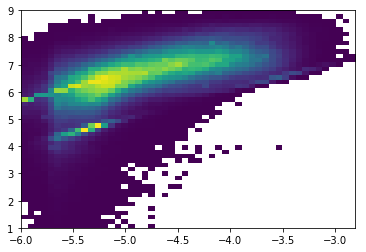

In [147]:
plt.hist2d(combined_input_data.loc[combined_output_data.iloc[:, 3] == 0, "QC_TAU_in"], 
           combined_input_data.loc[combined_output_data.iloc[:, 3] == 0, "NC_TAU_in"], bins=50, cmin=1)

In [143]:
np.count_nonzero((combined_output_data.iloc[:, 1] == 0) & (combined_output_data.iloc[:, 2] == 0))

0

In [144]:
np.count_nonzero(combined_output_data.iloc[:, 2] == 0)

0